# UMAP Theta-Gamma

This pipeline can be utilized for dimensionality reduction of cycle spectral signatures (high dimensional feature space) to a low dimensional UMAP space. Within the obtained UMAP manifold, groups of cycle spectral signatures can be identified and analyzed with respect to their mean spectral signature. Furthermore, the relationship between cycle metadata (e.g. behavioural condition) and the cycle´s position in the manifold can be studied.



# 1. Getting Started
## 1.1 Importing Libraries and Loading Non-Z-Scored and Z-Scored Cycle Spectral Signatures

In [2]:
import umap
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.spatial import cKDTree
import plotly.express as px
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import os
import glob
import h5py

In [4]:
# Load the saved non-z-scored spectral signatures
power_array = np.load(r'E:\Donders\Weekly meeting\PCA_ICA\power_array_non_zscored.npy')
print(power_array.shape)
# Load the saved z-scored spectral signatures
power_array2 = np.load(r'E:\Donders\Weekly meeting\PCA_ICA\power_array.npy')
print(power_array2.shape)

(125, 298536)
(125, 298536)


# 2. Dimensionality Reduction
## 2.1. Angle Based Intrinsic Dimensionality (ABID)
This method is utilized to estimate the number of reduced intrinsic dimensions of the high dimensional dataset.The result can thereby be taken as an ideal input for UMAP.

The following papers were used as a blueprint for implementing ABID in this pipeline:

Thordsen, E., & Schubert, E. (2020). ABID: angle based intrinsic dimensionality. In Similarity Search and Applications: 13th International Conference, SISAP 2020, Copenhagen, Denmark, September 30–October 2, 2020, Proceedings 13 (pp. 218-232). Springer International Publishing.

Sebastian, E. R., Quintanilla, J. P., Sánchez-Aguilera, A., Esparza, J., Cid, E., & de la Prida, L. M. (2023). Topological analysis of sharp-wave ripple waveforms reveals input mechanisms behind feature variations. Nature Neuroscience, 1-11.

In [4]:
#Angle Based Intrinsic Dimensionality
def abids(X, k):
    search_struct = cKDTree(X)
    return np.array([
        abid(X, k, x, search_struct)
        for x in tqdm(X, desc="abids", leave=False)
    ])

def abid(X, k, x, search_struct, offset=1):
    neighbor_norms, neighbors = search_struct.query(x, k + offset)
    neighbors = X[neighbors[offset:]] - x
    normed_neighbors = neighbors / neighbor_norms[offset:, None]
    para_coss = normed_neighbors.T.dot(normed_neighbors)
    return k**2 / np.sum(np.square(para_coss))


# Set the value of k (number of neighbors)
k_value = 50

# Call abids function on your dataset
ID = np.round(np.nanmean(abids(power_array.T, k_value)))

print('Intrinsic dimension = %d' % int(ID))

Intrinsic dimension = 6


## 2.2 UMAP with ABID output
The number of intrinsic dimensions of the dataset, identified by ABID, was taken as 'n_components' parameter. A random state was indicated for potential stability checks. Apart from that, UMAP was performed in default mode as indicated in the following paper:

Sebastian, E. R., Quintanilla, J. P., Sánchez-Aguilera, A., Esparza, J., Cid, E., & de la Prida, L. M. (2023). Topological analysis of sharp-wave ripple waveforms reveals input mechanisms behind feature variations. Nature Neuroscience, 1-11.

The different UMAP manifold is visualized in a scatterplot matrix to display all combinations of interactions between 2 dimensions. The diagonal represents the distribution of cycle spectral signatures for one specific dimension.

C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


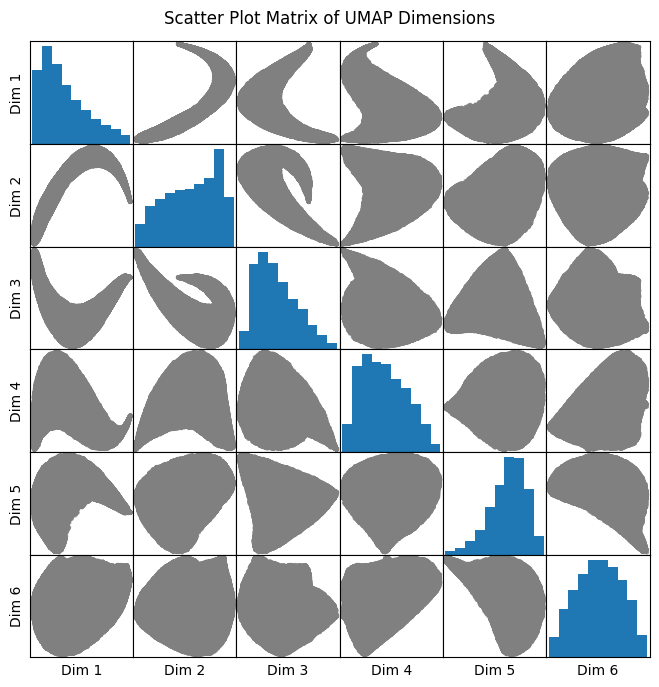

In [12]:
# Step 1: Apply UMAP to reduce dimensionality to 6D
reducer = umap.UMAP(n_components=6, random_state=58)
embedding = reducer.fit_transform(power_array.T)

# Step 2: Convert the result to a DataFrame for easy plotting
df = pd.DataFrame(data=embedding, columns=[f'Dim {i+1}' for i in range(6)])

# Step 3: Visualize the data using a scatter plot matrix
scatter_matrix = pd.plotting.scatter_matrix(df, alpha=0.8, figsize=(8, 8), diagonal='hist', color='grey')
plt.suptitle('Scatter Plot Matrix of UMAP Dimensions', y=0.92)

# Remove axis ticks and their values
for ax in scatter_matrix.flatten():
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])




## 2.3. UMAP with a Reduction to 2 Dimensions
For easier manifold grouping, and more interpretable projection of metadata, the UMAP was performed in default mode, which implies a reduction to 2 dimensions with 'n_components=2'. A 'random_state' was indicated for potential stability checks.

A similar approach to reduce the previously identified ABID dimensions further to 2 UMAP dimensions was taken in the following paper:

Sebastian, E. R., Quintanilla, J. P., Sánchez-Aguilera, A., Esparza, J., Cid, E., & de la Prida, L. M. (2023). Topological analysis of sharp-wave ripple waveforms reveals input mechanisms behind feature variations. Nature Neuroscience, 1-11.

C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\janlu\AppData\Local\Temp\ipykernel_4728\153246809.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='viridis')


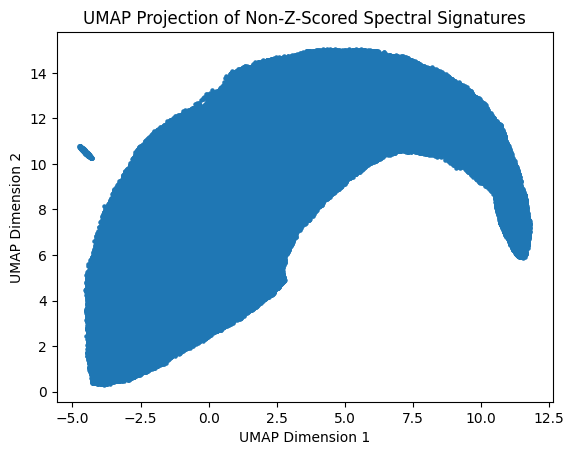

In [5]:
# Step 1: Apply UMAP to reduce dimensionality
reducer = umap.UMAP(random_state=58)
embedding = reducer.fit_transform(power_array.T)

# Step 2: Visualize the data (optional)
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='viridis')
plt.title('UMAP Projection of Non-Z-Scored Spectral Signatures')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()








# 3. Grouping of 2D UMAP Manifold
## 3.1. K-Means Clustering of 2D UMAP Manifold
To get an overview of how cycle spectral signatures evolve over the manifold, k-means clustering was performed. The ideal amount number of clusters 'n_clusters' can be identified by the elbow method. The "elbow" point of the curve for the number of clusters at which the change in sum of squared distances becomes minimal is taken as the optimal cluster number 'k'. This avoids under or overfitting during k-means clustering. For each cluster, the cycle indices are stored for spectral signature analysis.

Note: 
Clustering is not an ideal method to show groups in a continious manifold! During k-means clustering, each cluster has a different amount of cycles. An ideal method should group the manifold into multiple groups with an equivalent amount of cycles. For better trend analysis, the number of groups within the manifold should be increased.

C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\clus

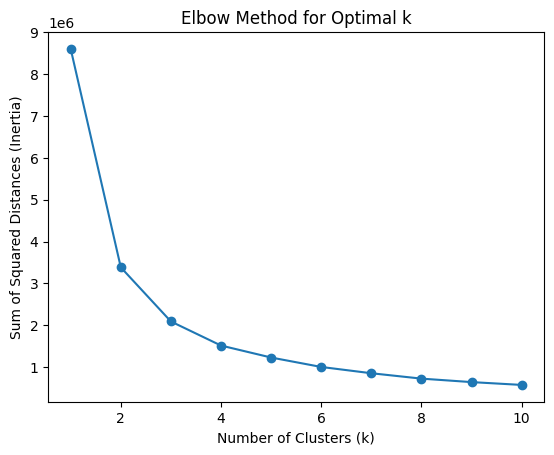

In [6]:
#Determine the optimal number of clusters (k) using the elbow method

# Create an empty list to store the sum of squared distances (inertia) for different k values
inertia_values = []

# Try different values of k (e.g., from 1 to 10)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=58)
    kmeans.fit(embedding)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.show()


C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


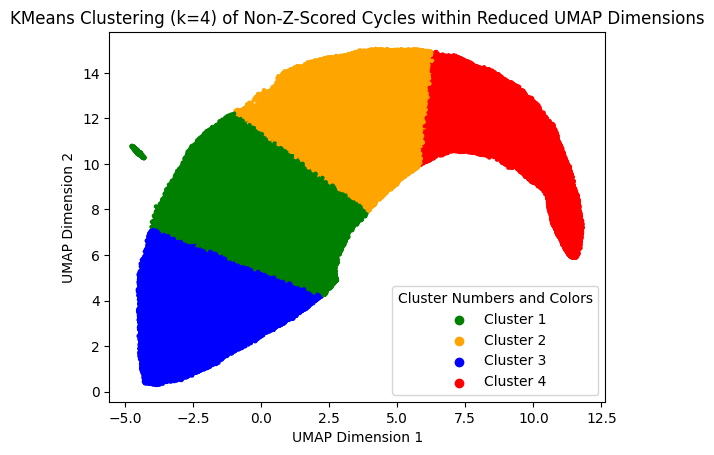

97237
cluster1_indices: [     0      2      7 ... 298532 298534 298535], Number of indices: 97237
78348
cluster2_indices: [    21     32     33 ... 298528 298529 298531], Number of indices: 78348
80668
cluster3_indices: [     1      3      4 ... 298523 298525 298533], Number of indices: 80668
42283
cluster4_indices: [   277    477    493 ... 298484 298492 298516], Number of indices: 42283


In [7]:
# Choose the optimal number of clusters (replace 'optimal_k' with the identified value)
optimal_k = 4  # replace with the optimal k value
lightorange = (1.0, 0.8, 0.6)
# Apply KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=58)
clusters = kmeans.fit_predict(embedding)

# Manually specify colors for each cluster
cluster_colors = ['green', 'orange', 'blue', 'red']

# Create dummy scatter plots for legend
dummy_scatters = []
for i in range(optimal_k):
    dummy_scatter = plt.scatter([], [], c=cluster_colors[i], label=f'Cluster {i + 1}')
    dummy_scatters.append(dummy_scatter)

# Visualize the clustered data with the specified colors
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=[cluster_colors[i] for i in clusters], s=5)

# Add legend with cluster numbers and colors
legend_labels = [f'Cluster {i + 1}' for i in range(optimal_k)]
plt.legend(handles=dummy_scatters, labels=legend_labels, title='Cluster Numbers and Colors')

# Add labels for UMAP dimensions
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.title(f'KMeans Clustering (k={optimal_k}) of Non-Z-Scored Cycles within Reduced UMAP Dimensions')
plt.show()

# Identify indices for each cluster
cluster_indices = [np.where(clusters == i)[0] for i in range(optimal_k)]

# Display indices and the number of indices for each cluster
for i, indices in enumerate(cluster_indices):
    cluster_name = f'cluster{i + 1}_indices'
    globals()[cluster_name] = indices
    num_indices = len(indices)
    print(num_indices)
    print(f'{cluster_name}: {indices}, Number of indices: {num_indices}')





## 3.2. Mean Spectral Signatures for Identified Manifold Groups
The mean over all cycle spectral signatures within one group is herein calculated.

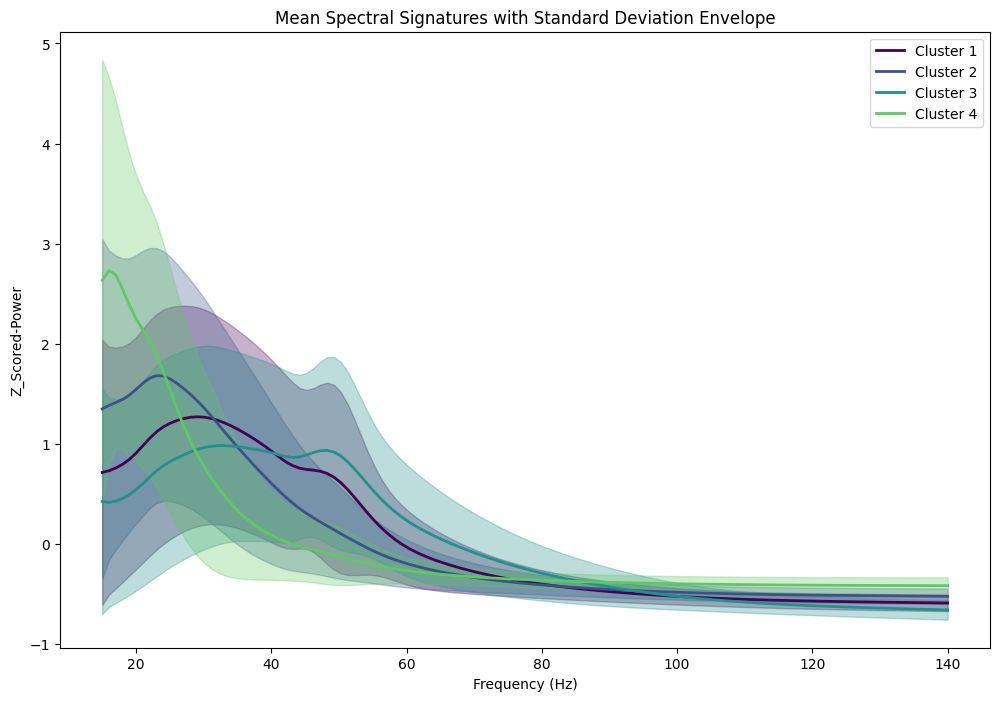

In [8]:
# Initialize lists to store mean and std spectral signatures for each cluster
cluster_mean_spectra = []
cluster_std_envelopes = []

# Extract cycles for each cluster and calculate mean and std spectral signatures
for indices in cluster_indices:
    cluster_cycles = power_array2[:, indices]
    mean_spectral_signature = np.mean(cluster_cycles, axis=1)
    std_spectral_signature = np.std(cluster_cycles, axis=1)
    cluster_mean_spectra.append(mean_spectral_signature)
    cluster_std_envelopes.append(std_spectral_signature)

# Plot mean spectral signature with std envelope for each cluster
plt.figure(figsize=(12, 8))
frequency_range = np.linspace(15, 140, num=125)  # Assuming a linear frequency range from 15Hz to 140Hz

for i, (mean_spec, std_env) in enumerate(zip(cluster_mean_spectra, cluster_std_envelopes)):
    cluster_color = plt.cm.viridis(i / optimal_k)  # Use the same color as in the scatter plot
    plt.plot(frequency_range, mean_spec, label=f'Cluster {i + 1}', color=cluster_color, linewidth=2)
    plt.fill_between(frequency_range, mean_spec - std_env, mean_spec + std_env, color=cluster_color, alpha=0.3)

plt.title('Mean Spectral Signatures with Standard Deviation Envelope')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Z_Scored-Power')
plt.legend()
plt.show()

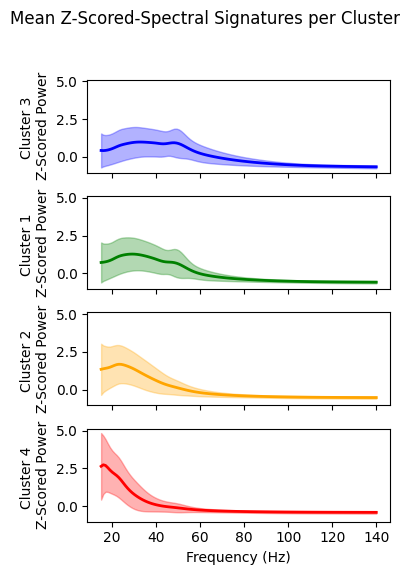

In [9]:
# Define the desired order of clusters
desired_order = [2, 0, 1, 3]  # Indices are 0-based, so 2 corresponds to Cluster 3, 0 to Cluster 1, and so on

# Specify colors for each cluster
cluster_colors = ['blue', 'green', 'orange', 'red']

# Plot mean spectral signature with std envelope for each cluster in separate subplots
fig, axs = plt.subplots(optimal_k, 1, figsize=(4, 6), sharex=True, sharey=True)
frequency_range = np.linspace(15, 140, num=125)  # Assuming a linear frequency range from 15Hz to 140Hz

for i, cluster_index in enumerate(desired_order):
    mean_spec, std_env = cluster_mean_spectra[cluster_index], cluster_std_envelopes[cluster_index]
    cluster_color = cluster_colors[i]
    
    axs[i].plot(frequency_range, mean_spec, label=f'Cluster {cluster_index + 1}', color=cluster_color, linewidth=2)
    axs[i].fill_between(frequency_range, mean_spec - std_env, mean_spec + std_env, color=cluster_color, alpha=0.3)
    axs[i].set_ylabel(f'Cluster {cluster_index + 1} \nZ-Scored Power')

plt.suptitle('Mean Z-Scored-Spectral Signatures per Cluster')
plt.xlabel('Frequency (Hz)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the top margin for the suptitle
plt.show()




# 4. Relating 2D UMAP Manifold to Metadata
## 4.1. Access and Store Metadata for each Cycle Spectral Signature
This part of the code calculates spectral signatures for each cycle and stores it in a dataframe with corresponding metadata (behavioural condition, posttrial, REM period and cycle number). From this dataframe additional "group" dataframes are generated (number of "group" dataframes corresponding to the number of identified groups). Thereby the spectral signatures and their metadata are classified into the previously identified groups.

In [12]:
# Define the root folder containing '1', '3','4', '6', '9', '11', '13' folders
root_folder = r"E:\Donders"

# Define the target folders
target_folders = ['1', '3', '4', '9', '11', '13']
frequency_array = np.arange(15, 140, 1)
folder_info_list = []

# Create a DataFrame to store the folder information
columns = ['Condition', 'Session_Date', 'REM_Period', 'Cycle_Number']
folder_df = pd.DataFrame(columns=columns)

for target_folder in target_folders:
    # Construct the path to the processed folders
    processed_folder = os.path.join(root_folder, target_folder, 'processed')

    # Iterate through subfolders in processed folder
    for subfolder in os.listdir(processed_folder):
        subfolder_path = os.path.join(processed_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Iterate through sub-subfolders (containing datasets)
            for dataset_folder in os.listdir(subfolder_path):
                dataset_folder_path = os.path.join(subfolder_path, dataset_folder)

                # Check if it's a directory
                if os.path.isdir(dataset_folder_path):
                    # Use glob to get all .h5 files in the dataset folder
                    hdf5_files = glob.glob(os.path.join(dataset_folder_path, '*.h5'))

                    # Iterate over each .h5 file
                    for hdf5_file_path in hdf5_files:
                        # Open the HDF5 file in read mode
                        with h5py.File(hdf5_file_path, 'r') as hdf_file:
                            # Iterate over all groups in the file
                            for group_name in hdf_file.keys():
                                # Access the current group
                                current_group = hdf_file[group_name]
                                
                                # Continue with your processing for the current group
                                rem_dict_keys = list(current_group.keys())

                                for rem_key in rem_dict_keys:
                                    # Access the 'Cycles' key to get the cycle indices
                                    cycle_indices = hdf_file[group_name][rem_key]['Cycles'][:]
                                    
                                    # Append the folder information to the list for each cycle
                                    for cycle_index in cycle_indices:
                                        folder_info_list.append({
                                            'Condition': subfolder,
                                            'Session_Date': dataset_folder,
                                            'REM_Period': rem_key,
                                            'Cycle_Number': cycle_index  # Using cycle_index as the cycle number
                                        })

# Convert the list of dictionaries to a DataFrame
folder_df = pd.DataFrame(folder_info_list)

# Add a new column 'Cycle_Number' with the row index as values
folder_df['Cycle_Number'] = folder_df.index

# Save the DataFrame to a CSV file
folder_df.to_csv("2folder_information_with_cycle_number.csv", index=False)

In [13]:
# Load the original folder information DataFrame
folder_info_df = pd.read_csv("2folder_information_with_cycle_number.csv")


# Create DataFrames for each cluster based on the cluster indices
cluster1_df = folder_info_df[folder_info_df['Cycle_Number'].isin(cluster1_indices)].copy()
cluster2_df = folder_info_df[folder_info_df['Cycle_Number'].isin(cluster2_indices)].copy()
cluster3_df = folder_info_df[folder_info_df['Cycle_Number'].isin(cluster3_indices)].copy()
cluster4_df = folder_info_df[folder_info_df['Cycle_Number'].isin(cluster4_indices)].copy()

# Save each cluster DataFrame to a separate CSV file
cluster1_df.to_csv("cluster1_info.csv", index=False)
cluster2_df.to_csv("cluster2_info.csv", index=False)
cluster3_df.to_csv("cluster3_info.csv", index=False)
cluster4_df.to_csv("cluster4_info.csv", index=False)



## 4.2. Behavioural Conditions and their Distribution of Manifold Groups
In the following part of the script, the distribution of identified groups per behavioural condition of the object space task (OD=stable, OR=overlapping, OR_N=overlapping with novelty exposure, CN=random, HC=Homecage as time-of-day control) is investigated.

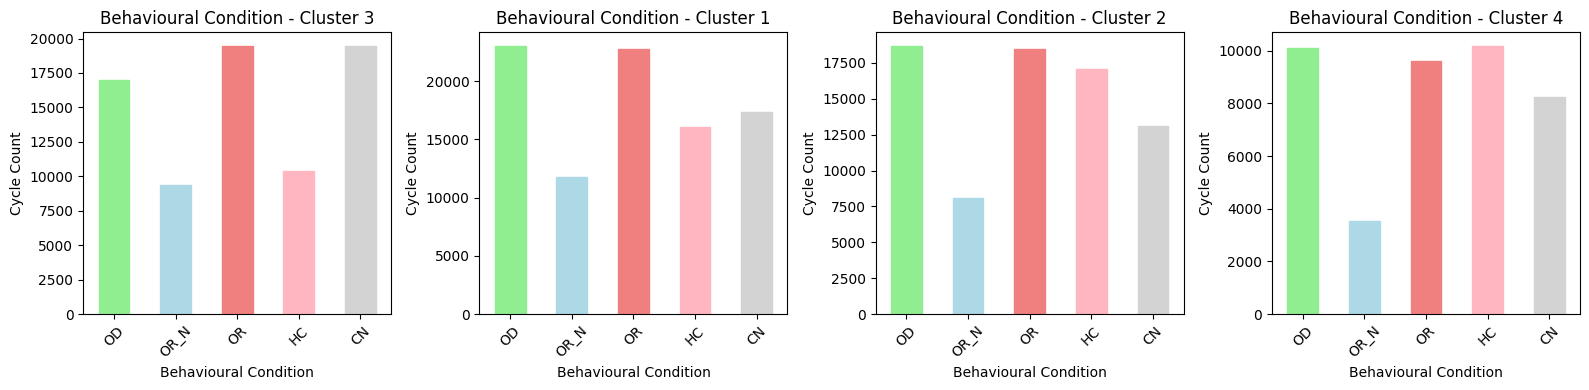

In [15]:
def create_and_save_condition_histograms(cluster_df, cluster_name, ax):
    # Define the desired order of condition prefixes
    condition_order = ['OD', 'OR_N', 'OR', 'HC', 'CN']

    # Extract the rat name prefix from 'Condition'
    cluster_df['Condition_Prefix'] = cluster_df['Condition'].str.extract(r'(OD|(?:OR_N|OR)|HC|CN)')

    # Group the DataFrame by 'Condition_Prefix' and count occurrences
    condition_histogram = cluster_df['Condition_Prefix'].value_counts()

    # Sort the histogram according to the custom order
    condition_histogram = condition_histogram.reindex(condition_order)

    # Plot the histogram in the specified subplot
    condition_histogram.plot(kind='bar', color='lightgreen', ax=ax)
    ax.set_title(f'Behavioural Condition - Cluster {cluster_name}')
    ax.set_xlabel('Behavioural Condition')
    ax.set_ylabel('Cycle Count')
    ax.tick_params(axis='x', rotation=45)


# Define the desired order of condition prefixes
condition_order = ['OD', 'OR_N', 'OR', 'HC', 'CN']

# Create a 1x4 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

# Define the order of clusters and corresponding dataframes
cluster_order = [3, 1, 2, 4]
dataframes = [cluster3_df, cluster1_df, cluster2_df, cluster4_df]

# Define colors for each rat name
condition_colors = {'OD': 'lightgreen', 'OR_N': 'lightblue', 'OR': 'lightcoral', 'HC': 'lightpink', 'CN': 'lightgrey'}

# Create and save histograms for each cluster based on condition prefixes in subplots
for cluster, ax, df in zip(cluster_order, axes, dataframes):
    create_and_save_condition_histograms(df, cluster, ax)
    # Set colors for each bar in the histogram based on condition
    for bar, color in zip(ax.patches, [condition_colors[name] for name in condition_order]):
        bar.set_color(color)

# Adjust layout for better spacing
plt.tight_layout()

# Save the entire figure
plt.savefig("behavioural_condition_histogram_subplots.png")

# Show the plot
plt.show()



C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


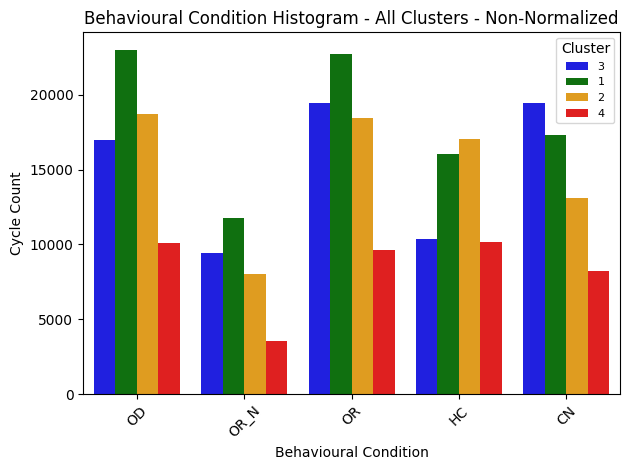

In [16]:

# Define the desired order of rat name prefixes
rat_name_order = ['OD', 'OR_N', 'OR', 'HC', 'CN']

# Define the order of clusters and corresponding dataframes
cluster_order = [3, 1, 2, 4]
dataframes = [cluster3_df, cluster1_df, cluster2_df, cluster4_df]

# Define colors for each cluster
cluster_colors = {3: 'blue', 1: 'green', 2: 'orange', 4: 'red'}

# Concatenate the dataframes for different clusters
all_clusters_df = pd.concat([df.assign(Cluster=cluster) for df, cluster in zip(dataframes, cluster_order)])

# Extract the rat name prefix from 'Condition'
all_clusters_df['Condition_Prefix'] = all_clusters_df['Condition'].str.extract(r'(OD|(?:OR_N|OR)|HC|CN)')

# Set the order of 'Rat_Name_Prefix' based on the condition_order list
all_clusters_df['Condition_Prefix'] = pd.Categorical(all_clusters_df['Condition_Prefix'], categories=condition_order, ordered=True)

# Create a bar plot using seaborn with specified order and colors
sns.set_palette([cluster_colors[cluster] for cluster in cluster_order])
sns.countplot(data=all_clusters_df, x='Condition_Prefix', hue='Cluster', order=condition_order, hue_order=cluster_order)

plt.title('Behavioural Condition Histogram - All Clusters - Non-Normalized')
plt.xlabel('Behavioural Condition')
plt.ylabel('Cycle Count')
plt.xticks(rotation=45)

# Adjust the legend fontsize
plt.legend(title='Cluster', fontsize='8')

# Save the entire figure
plt.tight_layout()
plt.savefig("behavioural_condition_histogram_all_clusters_ordered.png")
plt.show()


In [18]:
# Count the total occurrences of each Condition Prefix
total_counts = all_clusters_df['Condition_Prefix'].value_counts()

# Print the total counts for each Condition Prefix
for prefix, count in total_counts.items():
    print(f'Total {prefix}: {count}')



Total OR: 70267
Total OD: 68845
Total CN: 58136
Total HC: 53681
Total OR_N: 32777


C:\Users\janlu\AppData\Local\Temp\ipykernel_4728\4214213269.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts_per_cluster = all_clusters_df.groupby(['Cluster', 'Condition_Prefix']).size().reset_index(name='Total_Count')
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

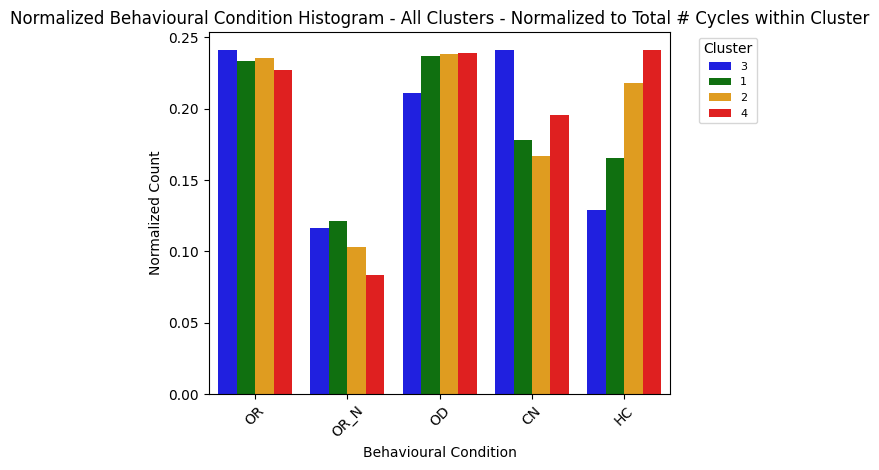

In [26]:
# Define the desired order of condition prefixes
condition_order = ['OR', 'OR_N', 'OD', 'CN', 'HC']

# Define the order of clusters and corresponding dataframes
cluster_order = [3, 1, 2, 4]
dataframes = [cluster3_df, cluster1_df, cluster2_df, cluster4_df]

# Define colors for each cluster
cluster_colors = {3: 'blue', 1: 'green', 2: 'orange', 4: 'red'}

# Concatenate the dataframes for different clusters
all_clusters_df = pd.concat([df.assign(Cluster=cluster) for df, cluster in zip(dataframes, cluster_order)])

# Extract the rat name prefix from 'Condition'
all_clusters_df['Condition_Prefix'] = all_clusters_df['Condition'].str.extract(r'(OD|(?:OR_N|OR)|HC|CN)')

# Set the order of 'Condition_Prefix' based on the condition_order list
all_clusters_df['Condition_Prefix'] = pd.Categorical(all_clusters_df['Condition_Prefix'], categories=condition_order, ordered=True)

# Count the total occurrences of each Condition Prefix within each cluster
total_counts_per_cluster = all_clusters_df.groupby(['Cluster', 'Condition_Prefix']).size().reset_index(name='Total_Count')

# Count the total occurrences of each Condition Prefix within each cluster (summing together all conditions)
total_counts_all_clusters = all_clusters_df.groupby(['Cluster']).size().reset_index(name='Total_Count_All_Clusters')

# Merge the total counts back to the original dataframe
all_clusters_df = pd.merge(all_clusters_df, total_counts_per_cluster, on=['Cluster', 'Condition_Prefix'])
all_clusters_df = pd.merge(all_clusters_df, total_counts_all_clusters, on='Cluster')

# Normalize counts within each cluster
all_clusters_df['Normalized_Count'] = all_clusters_df['Total_Count'] / all_clusters_df['Total_Count_All_Clusters']

# Create a bar plot using seaborn with specified order and colors
sns.set_palette([cluster_colors[cluster] for cluster in cluster_order])
sns.barplot(data=all_clusters_df, x='Condition_Prefix', y='Normalized_Count', hue='Cluster', order=condition_order, hue_order=cluster_order)

plt.title('Normalized Behavioural Condition Histogram - All Clusters - Normalized to Total # Cycles within Cluster')
plt.xlabel('Behavioural Condition')
plt.ylabel('Normalized Count')
plt.xticks(rotation=45)

# Move the legend outside of the plot
plt.legend(title='Cluster', fontsize='8', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the entire figure
plt.tight_layout()
plt.savefig("normalized_behavioural_condition_histogram_all_clusters_ordered_with_legend.png")
plt.show()


C:\Users\janlu\AppData\Local\Temp\ipykernel_4728\3062535262.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts_per_cluster = all_clusters_df.groupby(['Cluster', 'Condition_Prefix']).size().reset_index(name='Total_Count')
C:\Users\janlu\AppData\Local\Temp\ipykernel_4728\3062535262.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts_all_clusters = all_clusters_df.groupby(['Cluster', 'Condition_Prefix']).size().groupby('Cluster').sum().reset_index(name='Total_Count_All_Clusters')
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: Future

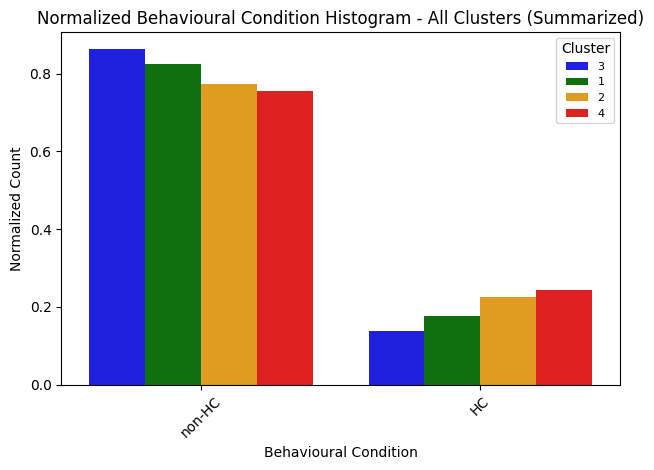

In [27]:
# Define the desired order of condition prefixes
condition_order = ['non-HC', 'HC']

# Define the order of clusters and corresponding dataframes
cluster_order = [3, 1, 2, 4]
dataframes = [cluster3_df, cluster1_df, cluster2_df, cluster4_df]

# Define colors for each cluster
cluster_colors = {3: 'blue', 1: 'green', 2: 'orange', 4: 'red'}

# Concatenate the dataframes for different clusters
all_clusters_df = pd.concat([df.assign(Cluster=cluster) for df, cluster in zip(dataframes, cluster_order)])

# Extract the rat name prefix from 'Condition'
all_clusters_df['Condition_Prefix'] = all_clusters_df['Condition'].str.extract(r'(OD|(?:OR_N|OR)|HC|CN)')

# Combine 'OD', 'OR_N', 'OR', 'CN' together
all_clusters_df['Condition_Prefix'] = all_clusters_df['Condition_Prefix'].replace({'OD': 'non-HC', 'OR_N': 'non-HC', 'OR': 'non-HC', 'CN': 'non-HC'})

# Set the order of 'Rat_Name_Prefix' based on the rat_name_order list
all_clusters_df['Condition_Prefix'] = pd.Categorical(all_clusters_df['Condition_Prefix'], categories=condition_order, ordered=True)

# Count the total occurrences of each Rat Name Prefix within each cluster
total_counts_per_cluster = all_clusters_df.groupby(['Cluster', 'Condition_Prefix']).size().reset_index(name='Total_Count')

# Count the total occurrences of each Rat Name Prefix within each cluster (summing together all conditions)
total_counts_all_clusters = all_clusters_df.groupby(['Cluster', 'Condition_Prefix']).size().groupby('Cluster').sum().reset_index(name='Total_Count_All_Clusters')

# Merge the total counts back to the original dataframe
all_clusters_df = pd.merge(all_clusters_df, total_counts_per_cluster, on=['Cluster', 'Condition_Prefix'])
all_clusters_df = pd.merge(all_clusters_df, total_counts_all_clusters, on='Cluster')

# Normalize counts within each behavioral condition separately
all_clusters_df['Normalized_Count'] = all_clusters_df['Total_Count'] / all_clusters_df['Total_Count_All_Clusters']

# Create a bar plot using seaborn with specified order and colors
sns.set_palette([cluster_colors[cluster] for cluster in cluster_order])
sns.barplot(data=all_clusters_df, x='Condition_Prefix', y='Normalized_Count', hue='Cluster', order=condition_order, hue_order=cluster_order)

plt.title('Normalized Behavioural Condition Histogram - All Clusters (Summarized)')
plt.xlabel('Behavioural Condition')
plt.ylabel('Normalized Count')
plt.xticks(rotation=45)

# Adjust the legend fontsize
plt.legend(title='Cluster', fontsize='8')

# Save the entire figure
plt.tight_layout()
plt.savefig("normalized_behavioural_condition_histogram_all_clusters_summarized.png")
plt.show()


## 4.3 Mapping Phase Information Into the Manifold

In [ ]:
#Getting spectral signatures of all rats
# Define the root folder containing '1', '3','4', '6', '9', '11', '13' folders
root_folder = r"E:\Donders"

# Define the target folders
target_folders = ['1', '3','4', '9', '11', '13']
phase_array = np.arange(-180, 180, 19)
power_list = []
fpp_list = []

for target_folder in target_folders:
    # Construct the path to the processed folders
    processed_folder = os.path.join(root_folder, target_folder, 'processed')

    # Iterate through subfolders in processed folder
    for subfolder in os.listdir(processed_folder):
        subfolder_path = os.path.join(processed_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Iterate through sub-subfolders (containing datasets)
            for dataset_folder in os.listdir(subfolder_path):
                dataset_folder_path = os.path.join(subfolder_path, dataset_folder)

                # Check if it's a directory
                if os.path.isdir(dataset_folder_path):
                    # Use glob to get all .h5 files in the dataset folder
                    hdf5_files = glob.glob(os.path.join(dataset_folder_path, '*.h5'))

                    # Iterate over each .h5 file
                    for hdf5_file_path in hdf5_files:
                        # Open the HDF5 file in read mode
                        with h5py.File(hdf5_file_path, 'r') as hdf_file:
                            # Iterate over all groups in the file
                            for group_name in hdf_file.keys():
                                # Access the current group
                                # Print debugging information
                                print(f"Processing file: {hdf5_file_path}")
                                print(f"Available groups: {list(hdf_file.keys())}")
                                current_group = hdf_file[group_name]
                                
                                # Continue with your processing for the current group
                                rem_dict_keys = list(current_group.keys())
                        

                                for rem_key in rem_dict_keys:
                                    # Access the 'IMFs' key to get the Intrinsic Mode Functions
                                    imfs = current_group[rem_key]['IMFs'] 
                                    print(imfs.shape)
                                    # Identify the indices of theta frequencies in the 'IMFs' array
                                    theta_range = (5, 12)
                                    sub_theta, theta, supra_theta = tg_split(current_group[rem_key]['IMF_Frequencies'], theta_range)

                                    # Extract IMFs corresponding to theta signals and sum them up
                                    supra_theta_imfs_sum = np.sum(imfs[:, supra_theta], axis=1)
 
                                    # Access the 'wavelet_transform' key for the current REM period
                                    wavelet_transform = morlet_wt(supra_theta_imfs_sum, 2500, frequency_array, n=5, mode='amplitude')
                                    # Square each value in the matrix to get power
                                    power_matrix = np.square(np.abs(wavelet_transform))
                                    print("shape power matrix:", power_matrix.shape)
                                    # Z-score along the time axis
                                    #power = zscore(power_matrix, axis=0)
                                
                                    start_end = hdf_file[group_name][rem_key]['start-end'][:]
                                    fpp_cycles = hdf_file[group_name][rem_key]['Cycles'][:]
                                    newcycles = fpp_cycles[:, [0, -1]] - start_end[0]

                                    # Calculate mean power values for the subset of frequencies
                                    fpp_plots = bin_tf_to_fpp(newcycles, power_matrix, 19)
                                    print("shape of fpp_plots", fpp_plots.shape)
                                    
                                    # Check if fpp_plots is 1D before attempting to calculate the mean along axis 2
                                    if len(fpp_plots.shape) > 1:
                                        fpp_list.append(fpp_plots)
                                        mean_along_axis_2 = (np.mean(fpp_plots, axis=1)).T
                                        print(mean_along_axis_2.shape)
                                        power_list.append(mean_along_axis_2)
                                        print("fpp_list length:", len(fpp_list))
                                    else:
                                        # Handle the case where fpp_plots is 1D (e.g., if there's an issue with the data)
                                        print("Error: Dimensions of fpp_plots are too small.")
#combined_fpp = np.concatenate(fpp_list, axis=0)
#print("combined_fpp shape is", combined_fpp.shape)
# Replace the original list comprehension for filtered_power_list
filtered_power_list = [arr for arr in power_list if len(arr.shape) > 0]

# Concatenate the filtered arrays
phase_power_array = np.concatenate(filtered_power_list, axis=1)
print(power_array.shape)

# Calculate the mean power across all cycles
phase_signature_mean = np.mean(phase_power_array, axis=1)

# Calculate the standard deviation across all cycles (instead of standard error of the mean)
phase_signature_std = np.std(phase_power_array, axis=1)

# Plot the mean power across all cycles
plt.plot(phase_array, phase_signature_mean, linestyle='-', color='blue', label='Phase Signature')

# Fill the area between mean - std and mean + std with a translucent color
plt.fill_between(phase_array, phase_signature_mean - phase_signature_std, phase_signature_mean + phase_signature_std, color='lightblue', alpha=0.3, label='Standard Deviation of phase Signature')

plt.xlabel('Phase')
plt.ylabel('Power')
plt.title(f'Phase signature non-z-scored - Rat: {target_folders}')
# Place the legend outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# Define the file path where you want to save the power_array
save_path = "phase_power_array.npy"

# Save the power_array
np.save(save_path, phase_power_array)

print(f"Power array saved to {save_path}")

In [36]:
# Define the path where the power_array is saved
load_path = "phase_power_array.npy"

# Load the power_array
phase_power_array = np.load(load_path)

C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\janlu\AppData\Local\Temp\ipykernel_4728\2159552502.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='viridis')


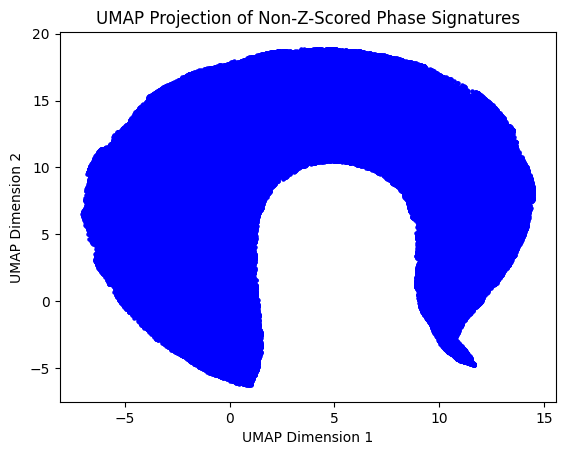

In [38]:
# Step 1: Apply UMAP to reduce dimensionality
reducer = umap.UMAP(random_state=58)
embedding = reducer.fit_transform(phase_power_array.T)

# Step 2: Visualize the data (optional)
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='viridis')
plt.title('UMAP Projection of Non-Z-Scored Phase Signatures')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

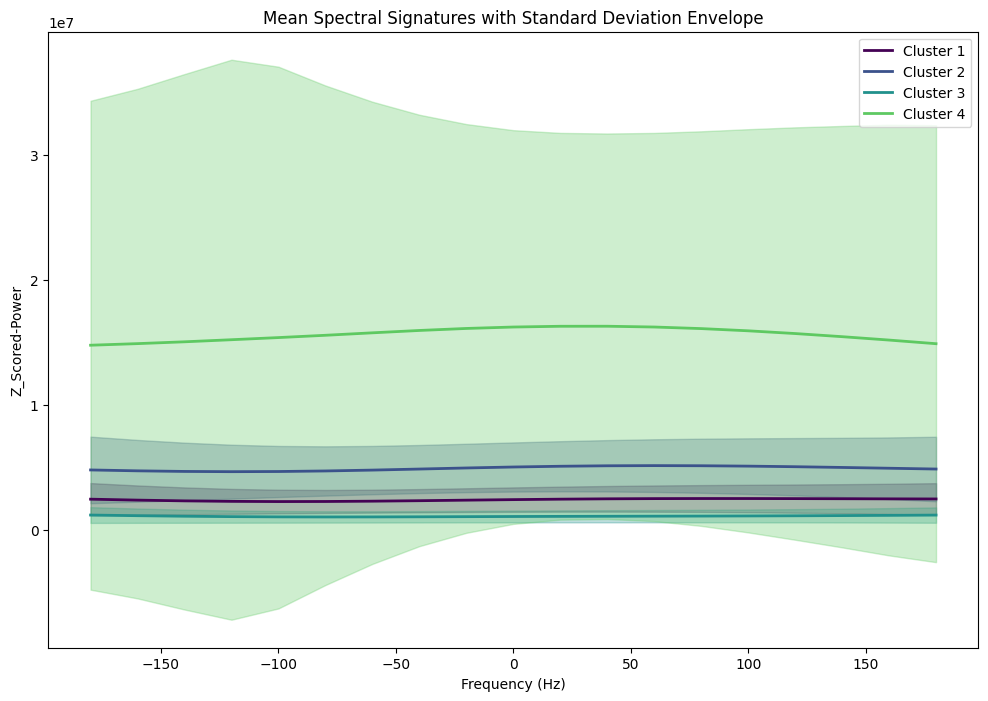

In [11]:
# Initialize lists to store mean and std spectral signatures for each cluster
cluster_mean_spectra = []
cluster_std_envelopes = []
phase_array = np.arange(-180, 180, 19)
# Extract cycles for each cluster and calculate mean and std spectral signatures
for indices in cluster_indices:
    cluster_cycles = phase_power_array[:, indices]
    mean_spectral_signature = np.mean(cluster_cycles, axis=1)
    std_spectral_signature = np.std(cluster_cycles, axis=1)
    cluster_mean_spectra.append(mean_spectral_signature)
    cluster_std_envelopes.append(std_spectral_signature)

# Plot mean spectral signature with std envelope for each cluster
plt.figure(figsize=(12, 8))
phase_range = np.linspace(-180, 180, num=19)  # Assuming a linear frequency range from 15Hz to 140Hz

for i, (mean_spec, std_env) in enumerate(zip(cluster_mean_spectra, cluster_std_envelopes)):
    cluster_color = plt.cm.viridis(i / optimal_k)  # Use the same color as in the scatter plot
    plt.plot(phase_range, mean_spec, label=f'Cluster {i + 1}', color=cluster_color, linewidth=2)
    plt.fill_between(phase_range, mean_spec - std_env, mean_spec + std_env, color=cluster_color, alpha=0.3)

plt.title('Mean Spectral Signatures with Standard Deviation Envelope')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Non-Z-Scored-Power')
plt.legend()
plt.show()

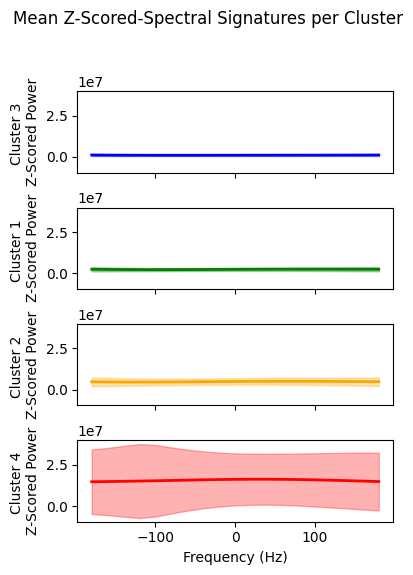

In [12]:
# Define the desired order of clusters
desired_order = [2, 0, 1, 3]  # Indices are 0-based, so 2 corresponds to Cluster 3, 0 to Cluster 1, and so on

# Specify colors for each cluster
cluster_colors = ['blue', 'green', 'orange', 'red']

# Plot mean spectral signature with std envelope for each cluster in separate subplots
fig, axs = plt.subplots(optimal_k, 1, figsize=(4, 6), sharex=True, sharey=True)
frequency_range = np.linspace(-180, 180, num=19)  # Assuming a linear frequency range from 15Hz to 140Hz

for i, cluster_index in enumerate(desired_order):
    mean_spec, std_env = cluster_mean_spectra[cluster_index], cluster_std_envelopes[cluster_index]
    cluster_color = cluster_colors[i]
    
    axs[i].plot(phase_range, mean_spec, label=f'Cluster {cluster_index + 1}', color=cluster_color, linewidth=2)
    axs[i].fill_between(phase_range, mean_spec - std_env, mean_spec + std_env, color=cluster_color, alpha=0.3)
    axs[i].set_ylabel(f'Cluster {cluster_index + 1} \nZ-Scored Power')

plt.suptitle('Mean Z-Scored-Spectral Signatures per Cluster')
plt.xlabel('Frequency (Hz)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the top margin for the suptitle
plt.show()

In [ ]:
# Determine the maximum value and corresponding phase bin for each spectral signature
max_values = np.max(phase_power_array, axis=0)  # Get maximum value for each spectral signature
max_phase_bins = np.argmax(phase_power_array, axis=0)  # Get the index of the maximum value for each spectral signature

# Define the file paths where you want to save the maximum values and phase bins as numpy arrays
max_values_save_path = "max_values.npy"
max_phase_bins_save_path = "max_phase_bins.npy"

# Save the maximum values and phase bins as numpy arrays
np.save(max_values_save_path, max_values)
np.save(max_phase_bins_save_path, max_phase_bins)

print(f"Maximum values saved to {max_values_save_path}")
print(f"Phase bins where maximum occurs saved to {max_phase_bins_save_path}")

C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


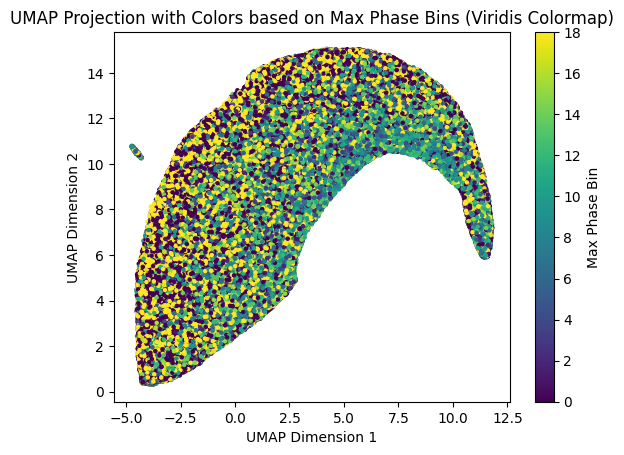

In [27]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Load the max_phase_bins numpy array
max_phase_bins = np.load("max_phase_bins.npy")

# Assuming power_array is already loaded or available

# Step 1: Apply UMAP to reduce dimensionality
reducer = umap.UMAP(random_state=58)
embedding = reducer.fit_transform(phase_power_array.T)

# Define normalization for color mapping
norm = Normalize(vmin=np.min(max_phase_bins), vmax=np.max(max_phase_bins))

# Step 2: Visualize the data with colors based on max_phase_bins using Viridis colormap
plt.scatter(embedding[:, 0], embedding[:, 1], c=max_phase_bins, cmap='viridis', s=5, norm=norm)
plt.title('UMAP Projection with Colors based on Max Phase Bins (Viridis Colormap)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Set colorbar ticks to show -180 to 180 degrees with 19 different colors
cbar = plt.colorbar(label='Max Phase Bin')


plt.show()

